# Train Masked Autoencoder

In [2]:

import os
import numpy as np
import pandas as pd
import ast
import torch
import torch.nn.functional as F
import joblib
from joblib import dump, load
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_curve
import random
from captum.attr import Saliency, IntegratedGradients, NoiseTunnel, LayerGradCam, GradientShap

from models.ConvolutionalAutoEncoderWithSkipAndTransformer import ConvolutionalAutoEncoderWithSkipAndTransformer

from trainer.maskdataloader import CustomDataset
from trainer.trainer_with_dataloader import ModelTrainer

patchsize= 4
maskratio=0.3


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    fig.set_figheight(4)
    fig.set_figwidth(8)
    axs.set_title(title or "Filter bank")
    cax1 = axs.imshow(fbank, aspect="auto", origin="lower", cmap='inferno')
    axs.set_ylabel("Frequency")
    axs.set_xlabel("Time")
    fig.colorbar(cax1, ax=axs, orientation='vertical', label='Intensity')


In [18]:
def show_example_from_dataset(dataset, index=0, title_prefix='Example'):
    masked_input, (original_input, mask) = dataset[index]
    
    # print(f"\n{title_prefix} {index}")
    # print(f"Original shape: {original_input.shape}")
    # print(f"Masked shape: {masked_input.shape}")
    # print(f"Mask shape: {mask.shape}")

    plot_fbank(original_input, f'{title_prefix}: Input')
    plot_fbank(masked_input, f'{title_prefix}: Masked Input')
    plot_fbank(mask, f'{title_prefix}: Mask')

    # Validate masking effect
    is_masked_diff = torch.all((masked_input == original_input)[mask == 1])
    is_unmasked_same = torch.all((masked_input == original_input)[mask == 0])

    # print("Masked regions unchanged?", is_masked_diff.item())  # Expect: False
    # print("Unmasked regions same?", is_unmasked_same.item())   # Expect: True

    data = [original_input, masked_input]
    titles = ['Original Input', 'Masked Input']

    # Create the pdf figure
    base_fontsize = 10.5
    plt.rcParams.update({
        'font.size': base_fontsize,
        'axes.labelsize': base_fontsize,
        'xtick.labelsize': base_fontsize - 2.5,
        'ytick.labelsize': base_fontsize - 1,
        'legend.fontsize': base_fontsize - 1,
        'figure.titlesize': base_fontsize,
    })
    fig, axes = plt.subplots(1, 2, figsize=(6.2, 2.0), sharey=True)#, constrained_layout=True)
    im = None
    for i, ax in enumerate(axes):
        im = ax.imshow(data[i].numpy(), aspect='auto', origin='lower', cmap='inferno')
        ax.set_xlabel("Time")
        ax.set_xticks(ticks=np.arange(0, original_input.shape[1], 50))
        if i == 0:
            ax.set_ylabel("Frequency")
        ax.set_title(titles[i], fontsize=base_fontsize)

    # One shared colorbar
    cbar = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.025, pad=0.04)
    cbar.set_label("Intensity", fontsize=base_fontsize)
    cbar.ax.tick_params(labelsize=base_fontsize - 1)

    plt.savefig('visualizations/MAEtrainnormal.pdf', format='pdf', bbox_inches='tight')
    plt.close()



## set train data

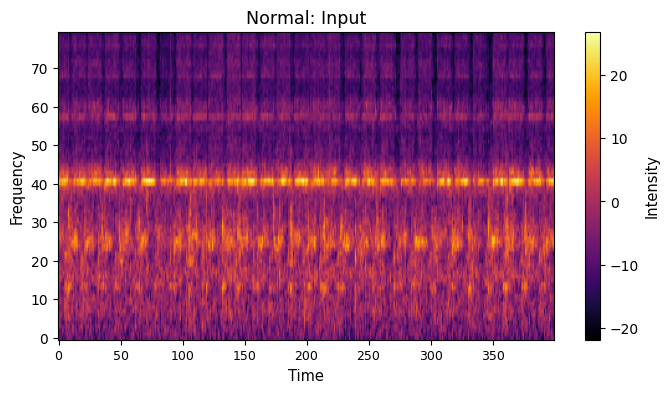

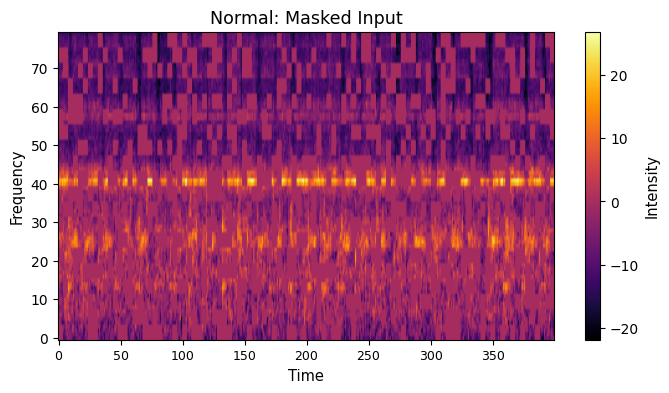

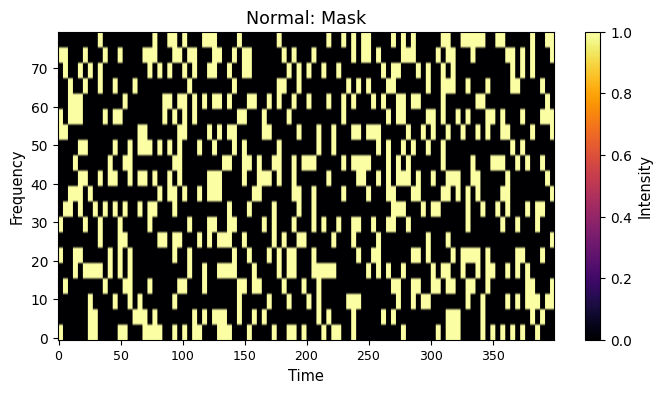

In [20]:

# Change this value to True to train the models and to False to evaluate the models on the evaluation dataset and
# generate the ROC curves
train = True
seed_value = 1986
torch.manual_seed(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

if train:
    d = CustomDataset([
        "data/training/2x3/",
        "data/training/2x4/",
        "data/training/2x6/",
        "data/training/machine_start_stop/"
    ], patch_size=(patchsize, patchsize), mask_ratio=maskratio) #, fixed_masking=True) # just for visualization for methodology
else:
    d = CustomDataset([
        "data/evaluation/normal/",
    ], patch_size=(patchsize, patchsize), mask_ratio=maskratio)

# visualize one sample from the normal dataset
show_example_from_dataset(d, index=888, title_prefix='Normal')



## train

Epoch:   1/500 Train steps: 121 Val steps: 13 1m2.61s loss: 122.500833 val_loss: 25.797642
Epoch:   2/500 Train steps: 121 Val steps: 13 48.00s loss: 24.491299 val_loss: 19.484888
Epoch:   3/500 Train steps: 121 Val steps: 13 47.27s loss: 20.664095 val_loss: 16.930565
Epoch:   4/500 Train steps: 121 Val steps: 13 47.27s loss: 17.947922 val_loss: 15.995864
Epoch:   5/500 Train steps: 121 Val steps: 13 47.55s loss: 17.659951 val_loss: 16.112340
Epoch:   6/500 Train steps: 121 Val steps: 13 47.45s loss: 17.814329 val_loss: 16.931683
Epoch:   7/500 Train steps: 121 Val steps: 13 48.10s loss: 18.485141 val_loss: 15.468740
Epoch:   8/500 Train steps: 121 Val steps: 13 47.13s loss: 16.217515 val_loss: 14.872989
Epoch:   9/500 Train steps: 121 Val steps: 13 47.55s loss: 15.187319 val_loss: 13.622536
Epoch:  10/500 Train steps: 121 Val steps: 13 47.82s loss: 14.265025 val_loss: 13.258053
Epoch:  11/500 Train steps: 121 Val steps: 13 47.62s loss: 24.973804 val_loss: 34.038953
Epoch:  12/500 Trai

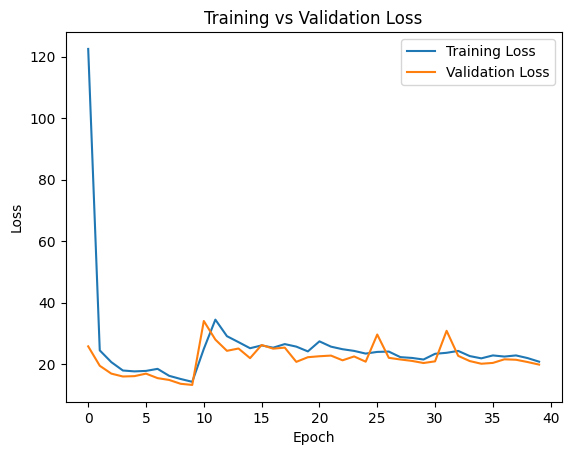

In [6]:
val_size = int(0.1 * len(d))

torch.manual_seed(seed_value)
train_set, val_set = torch.utils.data.random_split(d, [len(d) - val_size, val_size])

v_transformer_cae = ModelTrainer(num_input=400, num_input_channels=80, maskedae=True,
                                 batch_size=32,
                                 name=f"patched-mae-{patchsize}-{int(maskratio*100)}",
                                 network_class=ConvolutionalAutoEncoderWithSkipAndTransformer,
                                 lr=1e-3,
                                 loss=F.mse_loss)

v_transformer_cae.train(train_set, val_set)



# evaluate patched MAE

## set test data

In [8]:
# Change this value to True to train the models and to False to evaluate the models on the evaluation dataset and
# generate the ROC curves
train = False

seed_value = 1986
torch.manual_seed(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

if train:
    d = CustomDataset([
        "data/training/2x3/",
        "data/training/2x4/",
        "data/training/2x6/",
        "data/training/machine_start_stop/"
    ], patch_size=(patchsize, patchsize), mask_ratio=maskratio)
else:
    d = CustomDataset([
        "data/evaluation/normal/",
    ], patch_size=(patchsize, patchsize), mask_ratio=maskratio, fixed_masking=True)

d_anomalies = CustomDataset([
    "data/evaluation/anomalies/broken_board/",
    "data/evaluation/anomalies/board_stuck/",
    "data/evaluation/anomalies/Uneven_thick_wood/",
], patch_size=(patchsize, patchsize), mask_ratio=maskratio, fixed_masking=True)

print(len(d), len(d_anomalies))
y_true = np.zeros(len(d))
y_true_anomalies = np.ones(len(d_anomalies))

y_true = np.concatenate((y_true, y_true_anomalies))

val_size = int(0.1 * len(d))
torch.manual_seed(seed_value)
train_set, val_set = torch.utils.data.random_split(d, [len(d) - val_size, val_size])




3130 105


## evaluate MAE anomaly detection (AUC) using non masked inputs 
(full reconstruction error by setting maskedae=False (default value))

In [10]:
print(len(d), len(d_anomalies), patchsize, maskratio)

3130 105 4 0.3


In [11]:
train = False

v_transformer_cae = ModelTrainer(num_input=400, num_input_channels=80, # maskedae=True,
                                 batch_size=32,
                                 name=f"patched-mae-{patchsize}-{int(maskratio*100)}",
                                 network_class=ConvolutionalAutoEncoderWithSkipAndTransformer,
                                 lr=1e-3,
                                 loss=F.mse_loss)

v_transformer_cae.train(train_set, val_set)

if not train:
    datas = []
    
    print("Scoring normal data")
    for i, data in enumerate(d):
        if i % 100 == 0:
            print(i, "/", len(d))
        datas.append(data[1][0].reshape(80, -1).tolist()) # original input
        
    datas = torch.tensor(datas)
    losses_tensor = v_transformer_cae.get_loss(datas, reduction='none')
    losses_transformer = losses_tensor.view(losses_tensor.size(0), -1).mean(dim=1).tolist()

    print("Scoring anomalous data")
    datas_anomalies = []
    for i, data in enumerate(d_anomalies):
        datas_anomalies.append(data[1][0].reshape(80, -1).tolist())

    datas_anomalies = torch.tensor(datas_anomalies)
    losses_tensor_anomalies = v_transformer_cae.get_loss(datas_anomalies, reduction='none')
    losses_transformer_anomalies = losses_tensor_anomalies.view(losses_tensor_anomalies.size(0), -1).mean(dim=1).tolist()
    losses_transformer.extend(losses_transformer_anomalies)
    


Scoring normal data
0 / 3130
100 / 3130
200 / 3130
300 / 3130
400 / 3130
500 / 3130
600 / 3130
700 / 3130
800 / 3130
900 / 3130
1000 / 3130
1100 / 3130
1200 / 3130
1300 / 3130
1400 / 3130
1500 / 3130
1600 / 3130
1700 / 3130
1800 / 3130
1900 / 3130
2000 / 3130
2100 / 3130
2200 / 3130
2300 / 3130
2400 / 3130
2500 / 3130
2600 / 3130
2700 / 3130
2800 / 3130
2900 / 3130
3000 / 3130
3100 / 3130
Prediction steps: 98 1.30s                           
Scoring anomalous data
Prediction steps: 4 0.07s                          


Generating ROC curves
roc_auc of MAE=  0.829797657082002
roc_pauc of MAE=  0.7472755370855253


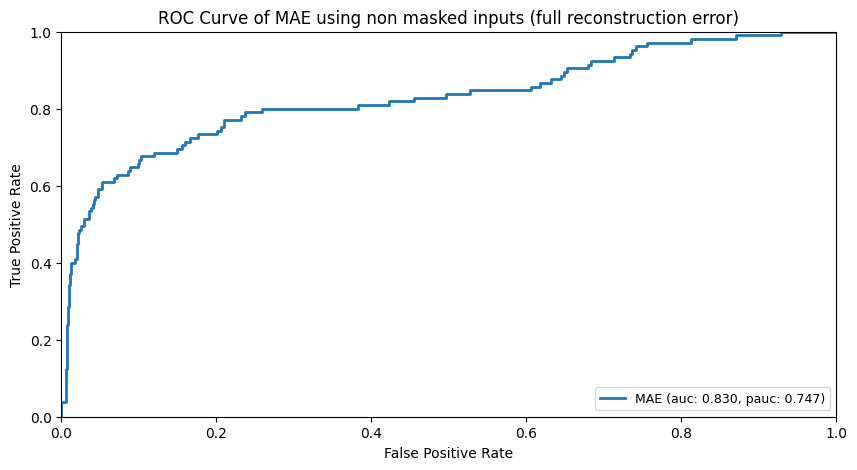

In [12]:

import matplotlib
import matplotlib.pyplot as plt

if not train:
    font = {'family': 'normal',
            'weight': 'bold',
            'size': 14}

    # matplotlib.rc('font', **font)

    print("Generating ROC curves")
    plt.figure(figsize=(10, 5))
    for legend, scores, line in [
        ("MAE", losses_transformer, 'solid'),
    ]:
        fpr, tpr, thresholds = roc_curve(y_true, scores)
        roc_auc = metrics.auc(fpr, tpr)
        roc_pauc = metrics.roc_auc_score(y_true, scores, max_fpr=0.1)
        print(f'roc_auc of {legend}= ', roc_auc)
        print(f'roc_pauc of {legend}= ', roc_pauc)

        plt.plot(fpr, tpr, label=f"{legend} (auc: %0.3f, pauc: %0.3f)" % (roc_auc, roc_pauc),
                 linewidth=2.0, linestyle=line)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve of MAE using non masked inputs (full reconstruction error)')
    plt.legend(loc="lower right", prop={'size': 9})
    plt.show()



# Qualitative and Quantitative Interpretability Evaluation of AE and MAE

## auxiliary functions

In [3]:

def load_annotations(csv_path):
    df = pd.read_csv(csv_path)
    annotation_dict = {}
    type_dict = {}
    
    for _, row in df.iterrows():
        fname = row["Spectrogram File Name"]
        raw_label = row["Labels in Spectrogram"]
        anomaly_type = row["Board (Anomaly) Type"]
        
        if raw_label.strip() == "-":
            continue  # Skip unannotated samples

        try:
            intervals = ast.literal_eval(raw_label)
            annotation_dict[fname] = intervals
            type_dict[fname] = anomaly_type
        except (ValueError, SyntaxError) as e:
            print(f"Warning: Could not parse label for {fname}: {raw_label}")
    
    return annotation_dict, type_dict

annotation_dict, type_dict = load_annotations("labelled_anomalies/v5anomaly_spectrogram_metadata.csv")
print(len(annotation_dict))

def compute_chunk_based_tp_fp_fn(peaks, annotations, total_frames, chunk_size=40):
    """
    Compute TP, FP, FN by dividing time into second chunks or segments

    Args:
        peaks: Indices of predicted peaks (e.g. [45, 88, 130, ...]).
        annotations: Ground truth intervals, e.g. [(120, 210), (300, 360)].
        total_frames: Total length of the sequence.
        chunk_size: Number of frames per chunk (default 40 = 1 second).

    Returns:
        tp, fp, fn
    """

    peaks = np.array(peaks)
    num_chunks = (total_frames + chunk_size - 1) // chunk_size  # ceil division

    tp = 0
    fp = 0
    fn = 0

    for i in range(num_chunks):
        chunk_start = i * chunk_size
        chunk_end = min((i + 1) * chunk_size, total_frames)

        # Check if this chunk overlaps with any annotation
        is_positive = any(
            not (chunk_end <= start or chunk_start >= end) for (start, end) in annotations
        )

        # Check if any peaks fall inside this chunk
        has_peak = np.any((peaks >= chunk_start) & (peaks < chunk_end))

        if is_positive and has_peak:
            tp += 1
        elif is_positive and not has_peak:
            fn += 1
        elif not is_positive and has_peak:
            fp += 1

    return tp, fp, fn


def chunk_based_f1(preds, gt_intervals):
    
    # WE GO FOR THIS APPROACH!!!!!!!!!!!!
    tp, fp, fn = compute_chunk_based_tp_fp_fn(preds, gt_intervals, total_frames=400)
    # If at least one peak occurs inside a positive (annotated) chunk → count as TP
    # If at least one peak occurs inside a non-annotated chunk → count as FP
    # If a positive chunk has no peaks → count as FN

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    return precision, recall, f1

    

46


In [4]:
# save annotated anomalous sample

def save_anomalous_sample(dataset, annotation_dict, index=2):
    masked_input, (original_input, mask), filepath = dataset[index]
    filename = os.path.basename(filepath)
    filename = os.path.basename(filepath)# get annotations
    if filename not in annotation_dict:
        print(f"No annotations found for: {filename}")
        return
    annotations = annotation_dict[filename]
    base_fontsize = 10.5
    plt.rcParams.update({
        'font.size': base_fontsize,
        'axes.labelsize': base_fontsize,
        'xtick.labelsize': base_fontsize - 0.5,
        'ytick.labelsize': base_fontsize - 0.5,
        'legend.fontsize': base_fontsize - 4,
        'figure.titlesize': base_fontsize,
    })
    fig, ax = plt.subplots(figsize=(4.5, 2.6))
    im = ax.imshow(original_input.numpy(), aspect='auto', origin='lower', cmap='inferno')
    for i, (start, end) in enumerate(annotations):
        if i == 0:
            ax.axvspan(start, end, color='blue', alpha=0.3, label='Human Annotation')
        else:
            plt.axvspan(start, end, color='blue', alpha=0.3)
    ax.set_xlabel("Time")
    ax.set_ylabel("Frequency")
    ax.set_title("Annotated Input", fontsize=base_fontsize)
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Intensity", fontsize=base_fontsize)
    ax.legend(loc='upper left')
    plt.tight_layout()
    plt.xticks(ticks=np.arange(0, original_input.shape[1], 50))

    plt.savefig("visualizations/annotated_sample.pdf", format='pdf', bbox_inches='tight')
    plt.close()

d_anomalies = CustomDataset([
    "data/evaluation/anomalies/broken_board/",
    "data/evaluation/anomalies/board_stuck/",
    "data/evaluation/anomalies/Uneven_thick_wood/",
], patch_size=(patchsize, patchsize), mask_ratio=maskratio, return_directory=True)
save_anomalous_sample(d_anomalies, annotation_dict, index=2)



In [5]:

def evaluate_attribution_map(curve, PEAK_PERCENTILE, annotations, normalize=True):
    """
    Evaluate an attribution map using region-level F1 and optional region accuracy.

    Args:
        curve: 1D array-like (raw attribution scores).
        PEAK_PERCENTILE: Float (e.g., 98) – threshold percentile for selecting top time steps.
        annotations: List of (start, end) tuples.
        normalize: Bool – whether to z-score normalize the curve.

    Returns:
        f1, precision, recall
    """
    curve_tensor = torch.tensor(curve) if isinstance(curve, np.ndarray) else curve.clone().detach()
    
    if normalize:
        curve_tensor = (curve_tensor - curve_tensor.mean()) / curve_tensor.std()
        
    threshold = torch.quantile(curve_tensor, PEAK_PERCENTILE / 100.0)
    binary = (curve_tensor >= threshold).int().numpy()  # shape [T]
    peaks = np.where(binary == 1)[0]
    
    # binary = np.zeros_like(norm_curve)
    # binary[peaks] = 1
    
    p, r, f1 = chunk_based_f1(peaks, annotations) # Approach2
    
    return f1, p, r
    
def threshold_map(map_2d, percentile=95): # for plotting binarized attribution maps
    # Ensure it's a NumPy array
    if isinstance(map_2d, torch.Tensor):
        map_2d = map_2d.cpu().numpy()
    thresh = np.percentile(map_2d, percentile)
    binary_map = (map_2d >= thresh).astype(float)
    return binary_map



In [6]:
def visualize_example(
    input_tensor, filename, annotations,
    error_map, saliency_map, ig_map, smoothgrad_map, gradcam_map, shap_map,
    error_curve, saliency_curve, ig_curve, smoothgrad_curve, gradcam_curve, shap_curve,
    percentiles=[95, 96, 97, 98, 99],
    method_name='MAE', board_type="Broken Board",
):
    base_fontsize = 10.5
    plt.rcParams.update({
        'font.size': base_fontsize,
        'axes.labelsize': base_fontsize,
        'xtick.labelsize': base_fontsize - 1.0,
        'ytick.labelsize': base_fontsize - 1.0,
        'legend.fontsize': base_fontsize - 1.0,
        'figure.titlesize': base_fontsize,
    })
    # input
    fig_inputs, ax_inputs = plt.subplots(1, 2, figsize=(6, 2.5))
    
    ax_inputs[0].imshow(input_tensor.cpu().numpy(), aspect='auto', origin='lower', cmap='inferno')
    ax_inputs[0].set_title("Input Spectrogram")
    ax_inputs[0].set_ylabel("Frequency")
    ax_inputs[0].set_xlabel("Time")
    
    ax_inputs[1].imshow(input_tensor.cpu().numpy(), aspect='auto', origin='lower', cmap='inferno')
    for (start, end) in annotations:
        ax_inputs[1].axvspan(start, end, color='blue', alpha=0.3)
    ax_inputs[1].set_title("Annotated Input")
    ax_inputs[1].set_xlabel("Time")

    fig_inputs.tight_layout()
    fig_inputs.savefig(f'visualizations/input_{method_name}.pdf', format='pdf', bbox_inches='tight')
    plt.close(fig_inputs)

    # attributions
    num_rows = 2 + len(percentiles)
    num_methods = 6
    base_fontsize = 20
    plt.rcParams.update({
        'font.size': base_fontsize,
        'axes.labelsize': base_fontsize,
        'xtick.labelsize': base_fontsize - 1.0,
        'ytick.labelsize': base_fontsize - 1.0,
        'legend.fontsize': base_fontsize - 1.0,
        'figure.titlesize': base_fontsize,
    })
    fig_attr, ax = plt.subplots(num_rows, num_methods, figsize=(6.0*num_methods, 2.5*num_rows), sharex=True)

    #  Row 0: Heatmaps
    maps = [error_map, saliency_map, ig_map, smoothgrad_map, gradcam_map, shap_map]
    titles = [
        f"[{method_name}] Reconstruction Error Map",
        f"[{method_name}] Saliency Map",
        f"[{method_name}] Integrated Gradients Map",
        f"[{method_name}] Smooth Grad Map",
        f"[{method_name}] Grad CAM Map",
        f"[{method_name}] Grad SHAP Map"
    ]
    for i in range(num_methods):
        ax[0, i].imshow(maps[i], aspect='auto', origin='lower', cmap='hot')
        ax[0, i].set_title(titles[i])
        ax[0, i].set_xticks(np.arange(0, input_tensor.shape[1]+1, 100)) ################################

    # Row 1: Binarized at 98th
    bin_perc = 98
    bin_maps = [
        threshold_map(error_map, bin_perc),
        threshold_map(saliency_map, bin_perc),
        threshold_map(ig_map, bin_perc),
        threshold_map(smoothgrad_map, bin_perc),
        threshold_map(gradcam_map, bin_perc),
        threshold_map(shap_map, bin_perc),
    ]
    for i in range(num_methods):
        ax[1, i].imshow(bin_maps[i], aspect='auto', origin='lower', cmap='inferno')
        ax[1, i].set_title(f"Binarized Map @{bin_perc}th")
        ax[1, i].set_xticks(np.arange(0, input_tensor.shape[1]+1, 100)) ################################

    # Row 2+: Curves
    curves = [error_curve, saliency_curve, ig_curve, smoothgrad_curve, gradcam_curve, shap_curve]
    method_labels = ["Error", "Saliency", "IG", "SmoothGrad", "GradCAM", "GradSHAP"]

    for col_idx, (curve, label) in enumerate(zip(curves, method_labels)):
        for row_offset, p in enumerate(percentiles):
            row_idx = 2 + row_offset
            ax_ = ax[row_idx, col_idx]
            curve_tensor = torch.tensor(curve) if isinstance(curve, np.ndarray) else curve.clone().detach()
            norm_curve = (curve_tensor - curve_tensor.mean()) / curve_tensor.std()
            threshold = torch.quantile(norm_curve, p / 100.0)
            binary = (norm_curve >= threshold).int().numpy()
            peaks = np.where(binary == 1)[0]

            ax_.plot(norm_curve, color='black')
            ax_.scatter(peaks, norm_curve[peaks], color='red', s=25, label=f"Peaks @ {p}th")

            for (start, end) in annotations:
                ax_.axvspan(start, end, color='blue', alpha=0.2)

            ax_.set_title(f"{label} - {p}th")
            if row_idx == len(percentiles) + 1:
                ax_.set_xlabel("Time")
            if col_idx == 0:
                ax_.set_ylabel(f"{p}th\nNorm")

    # fig_attr.suptitle(f"{board_type}", fontsize=14)
    fig_attr.tight_layout(rect=[0, 0, 1, 0.97])
    fig_attr.savefig(f'visualizations/attributions{method_name}.pdf', format='pdf', bbox_inches='tight')
    plt.close(fig_attr)



In [7]:

def compute_saliency_map(model, input_tensor):
    model.eval()
    device = next(model.parameters()).device  # detect model device
    input_tensor = input_tensor.unsqueeze(0).to(device).requires_grad_(True) # shape [1, C, H, W]

    # Forward pass: returns scalar reconstruction error
    def forward_fn(x):
        recon = model(x)
        error = F.mse_loss(recon, x, reduction='mean')
        return error.unsqueeze(0)  # returns [batch_size]

    saliency_analyzer = Saliency(forward_fn)
    attr = saliency_analyzer.attribute(input_tensor, target=None, abs=True)
    return attr.squeeze(0).detach().cpu().numpy()  # shape: [H, W]

def compute_integrated_gradients(model, input_tensor, baseline=None, steps=50):
    model.eval()
    device = next(model.parameters()).device
    input_tensor = input_tensor.unsqueeze(0).to(device).requires_grad_(True)
    if baseline is None:
        baseline = torch.zeros_like(input_tensor).to(device)

    def forward_fn(x):
        recon = model(x)
        return F.mse_loss(recon, x, reduction='mean').unsqueeze(0)

    ig = IntegratedGradients(forward_fn)
    attributions = ig.attribute(
        input_tensor,
        baselines=baseline,
        target=None,
        n_steps=steps,
        internal_batch_size=1,
        return_convergence_delta=False
    )
    return attributions.squeeze(0).detach().cpu().numpy()

def compute_smoothgrad(model, input_tensor, stdev=0.1, n_samples=25):
    model.eval()
    device = next(model.parameters()).device
    input_tensor = input_tensor.unsqueeze(0).to(device).requires_grad_(True)

    def forward_fn(x):
        recon = model(x)
        error = F.mse_loss(recon, x, reduction='mean')
        return error.unsqueeze(0)

    saliency = Saliency(forward_fn)
    smooth_saliency = NoiseTunnel(saliency)

    attributions = smooth_saliency.attribute(
        input_tensor,
        nt_type='smoothgrad',
        nt_samples=n_samples,
        stdevs=stdev,
        abs=True
    )

    return attributions.squeeze(0).detach().cpu().numpy()

def compute_gradcam(model, input_tensor, target_layer):
    model.eval()
    device = next(model.parameters()).device
    input_tensor = input_tensor.unsqueeze(0).to(device).requires_grad_(True)

    def forward_fn(x):
        recon = model(x)
        error = F.mse_loss(recon, x, reduction='mean')
        return error.unsqueeze(0)

    grad_cam = LayerGradCam(forward_fn, target_layer)

    attributions = grad_cam.attribute(input_tensor)

    # Interpolate to input resolution if needed
    upsampled_attr = torch.nn.functional.interpolate(
        attributions,
        size=input_tensor.shape[-2:],
        mode='bilinear',
        align_corners=False
    )

    return upsampled_attr.squeeze(0).detach().cpu().numpy()

def compute_gradient_shap(model, input_tensor, baseline=None, n_samples=25):
    model.eval()
    device = next(model.parameters()).device
    input_tensor = input_tensor.unsqueeze(0).to(device).requires_grad_(True)

    if baseline is None:
        # You can also try other baselines like input_tensor * 0 or noisy samples
        baseline = torch.zeros_like(input_tensor).to(device)

    def forward_fn(x):
        recon = model(x)
        return F.mse_loss(recon, x, reduction='mean').unsqueeze(0)

    gs = GradientShap(forward_fn)
    attributions = gs.attribute(
        input_tensor,
        baselines=baseline,
        n_samples=n_samples,
        stdevs=0.09,
    )
    return attributions.squeeze(0).detach().cpu().numpy()




In [8]:
print(set(type_dict.values()))


{'broken_board', 'board_stuck', 'Uneven_thick_wood'}


## compute f score

[AE] Model loaded...


  0%|          | 0/105 [00:00<?, ?it/s]

Prediction steps: 1 0.54s                          


  3%|▎         | 3/105 [00:04<02:20,  1.37s/it]

Prediction steps: 1 0.01s                          


 10%|█         | 11/105 [00:04<00:27,  3.46it/s]

Prediction steps: 1 0.01s                          
Prediction steps: 1 0.01s                          
Prediction steps: 1 0.01s                          


 14%|█▍        | 15/105 [00:07<00:35,  2.52it/s]

Prediction steps: 1 0.01s                          


 17%|█▋        | 18/105 [00:08<00:30,  2.82it/s]

Prediction steps: 1 0.01s                          


 22%|██▏       | 23/105 [00:08<00:22,  3.66it/s]

Prediction steps: 1 0.01s                          
Prediction steps: 1 0.01s                          


 24%|██▍       | 25/105 [00:10<00:28,  2.76it/s]

Prediction steps: 1 0.01s                          


 25%|██▍       | 26/105 [00:11<00:32,  2.46it/s]

Prediction steps: 1 0.01s                          


 27%|██▋       | 28/105 [00:11<00:30,  2.51it/s]

Prediction steps: 1 0.01s                          


 30%|██▉       | 31/105 [00:12<00:25,  2.89it/s]

Prediction steps: 1 0.01s                          


 33%|███▎      | 35/105 [00:13<00:19,  3.51it/s]

Prediction steps: 1 0.01s                          


 39%|███▉      | 41/105 [00:14<00:13,  4.67it/s]

Prediction steps: 1 0.01s                          


 45%|████▍     | 47/105 [00:14<00:10,  5.50it/s]

Prediction steps: 1 0.01s                          


 46%|████▌     | 48/105 [00:15<00:13,  4.36it/s]

Prediction steps: 1 0.01s                          


 47%|████▋     | 49/105 [00:16<00:15,  3.53it/s]

Prediction steps: 1 0.01s                          


 48%|████▊     | 50/105 [00:17<00:18,  2.91it/s]

Prediction steps: 1 0.01s                          


 52%|█████▏    | 55/105 [00:17<00:12,  3.99it/s]

Prediction steps: 1 0.01s                          


 55%|█████▌    | 58/105 [00:18<00:11,  3.99it/s]

Prediction steps: 1 0.01s                          


 56%|█████▌    | 59/105 [00:19<00:14,  3.26it/s]

Prediction steps: 1 0.01s                          


 58%|█████▊    | 61/105 [00:20<00:14,  3.09it/s]

Prediction steps: 1 0.01s                          


 59%|█████▉    | 62/105 [00:20<00:16,  2.59it/s]

Prediction steps: 1 0.01s                          


 60%|██████    | 63/105 [00:21<00:18,  2.23it/s]

Prediction steps: 1 0.01s                          


 62%|██████▏   | 65/105 [00:22<00:16,  2.38it/s]

Prediction steps: 1 0.01s                          


 64%|██████▍   | 67/105 [00:22<00:15,  2.48it/s]

Prediction steps: 1 0.01s                          


 66%|██████▌   | 69/105 [00:23<00:14,  2.56it/s]

Prediction steps: 1 0.01s                          


 67%|██████▋   | 70/105 [00:24<00:15,  2.21it/s]

Prediction steps: 1 0.01s                          


 69%|██████▊   | 72/105 [00:25<00:13,  2.36it/s]

Prediction steps: 1 0.01s                          


 70%|██████▉   | 73/105 [00:25<00:15,  2.07it/s]

Prediction steps: 1 0.01s                          


 73%|███████▎  | 77/105 [00:26<00:09,  3.04it/s]

Prediction steps: 1 0.01s                          


 74%|███████▍  | 78/105 [00:27<00:10,  2.55it/s]

Prediction steps: 1 0.01s                          


 75%|███████▌  | 79/105 [00:28<00:11,  2.20it/s]

Prediction steps: 1 0.01s                          


 78%|███████▊  | 82/105 [00:28<00:08,  2.75it/s]

Prediction steps: 1 0.01s                          


 83%|████████▎ | 87/105 [00:29<00:04,  3.89it/s]

Prediction steps: 1 0.01s                          


 84%|████████▍ | 88/105 [00:30<00:05,  3.15it/s]

Prediction steps: 1 0.01s                          


 85%|████████▍ | 89/105 [00:31<00:06,  2.63it/s]

Prediction steps: 1 0.01s                          


 86%|████████▌ | 90/105 [00:31<00:06,  2.26it/s]

Prediction steps: 1 0.01s                          


 87%|████████▋ | 91/105 [00:32<00:07,  2.00it/s]

Prediction steps: 1 0.01s                          


 92%|█████████▏| 97/105 [00:33<00:02,  3.76it/s]

Prediction steps: 1 0.01s                          


 94%|█████████▍| 99/105 [00:34<00:01,  3.45it/s]

Prediction steps: 1 0.01s                          


 95%|█████████▌| 100/105 [00:34<00:01,  2.84it/s]

Prediction steps: 1 0.01s                          


 96%|█████████▌| 101/105 [00:35<00:01,  2.42it/s]

Prediction steps: 1 0.01s                          


 98%|█████████▊| 103/105 [00:36<00:00,  2.50it/s]

Prediction steps: 1 0.01s                          


 99%|█████████▉| 104/105 [00:36<00:00,  2.17it/s]

Prediction steps: 1 0.01s                          


100%|██████████| 105/105 [00:37<00:00,  2.79it/s]


[MAE] Model loaded...


  0%|          | 0/105 [00:00<?, ?it/s]

Prediction steps: 1 0.01s                          


  3%|▎         | 3/105 [00:02<01:40,  1.02it/s]

Prediction steps: 1 0.01s                          


  4%|▍         | 4/105 [00:03<01:30,  1.11it/s]

Prediction steps: 1 0.01s                          


 11%|█▏        | 12/105 [00:04<00:24,  3.76it/s]

Prediction steps: 1 0.01s                          


 13%|█▎        | 14/105 [00:05<00:26,  3.49it/s]

Prediction steps: 1 0.01s                          


 14%|█▍        | 15/105 [00:05<00:31,  2.88it/s]

Prediction steps: 1 0.01s                          


 15%|█▌        | 16/105 [00:06<00:36,  2.45it/s]

Prediction steps: 1 0.01s                          


 22%|██▏       | 23/105 [00:07<00:18,  4.52it/s]

Prediction steps: 1 0.01s                          


 23%|██▎       | 24/105 [00:08<00:22,  3.61it/s]

Prediction steps: 1 0.01s                          


 24%|██▍       | 25/105 [00:08<00:27,  2.96it/s]

Prediction steps: 1 0.01s                          


 25%|██▍       | 26/105 [00:09<00:31,  2.51it/s]

Prediction steps: 1 0.01s                          


 27%|██▋       | 28/105 [00:10<00:29,  2.58it/s]

Prediction steps: 1 0.01s                          


 30%|██▉       | 31/105 [00:10<00:24,  3.04it/s]

Prediction steps: 1 0.01s                          


 33%|███▎      | 35/105 [00:11<00:18,  3.77it/s]

Prediction steps: 1 0.01s                          


 39%|███▉      | 41/105 [00:12<00:12,  5.06it/s]

Prediction steps: 1 0.01s                          


 45%|████▍     | 47/105 [00:13<00:09,  5.96it/s]

Prediction steps: 1 0.01s                          


 46%|████▌     | 48/105 [00:13<00:12,  4.62it/s]

Prediction steps: 1 0.01s                          


 47%|████▋     | 49/105 [00:14<00:15,  3.66it/s]

Prediction steps: 1 0.01s                          


 48%|████▊     | 50/105 [00:15<00:18,  2.99it/s]

Prediction steps: 1 0.01s                          


 52%|█████▏    | 55/105 [00:16<00:12,  4.15it/s]

Prediction steps: 1 0.01s                          


 55%|█████▌    | 58/105 [00:16<00:11,  4.13it/s]

Prediction steps: 1 0.01s                          


 56%|█████▌    | 59/105 [00:17<00:13,  3.29it/s]

Prediction steps: 1 0.01s                          


 58%|█████▊    | 61/105 [00:18<00:14,  3.13it/s]

Prediction steps: 1 0.01s                          


 59%|█████▉    | 62/105 [00:18<00:16,  2.61it/s]

Prediction steps: 1 0.01s                          


 60%|██████    | 63/105 [00:19<00:18,  2.26it/s]

Prediction steps: 1 0.01s                          


 62%|██████▏   | 65/105 [00:20<00:16,  2.40it/s]

Prediction steps: 1 0.01s                          


 64%|██████▍   | 67/105 [00:21<00:15,  2.51it/s]

Prediction steps: 1 0.01s                          


 66%|██████▌   | 69/105 [00:21<00:13,  2.58it/s]

Prediction steps: 1 0.01s                          


 67%|██████▋   | 70/105 [00:22<00:15,  2.22it/s]

Prediction steps: 1 0.01s                          


 69%|██████▊   | 72/105 [00:23<00:13,  2.38it/s]

Prediction steps: 1 0.01s                          


 70%|██████▉   | 73/105 [00:24<00:15,  2.08it/s]

Prediction steps: 1 0.01s                          


 73%|███████▎  | 77/105 [00:24<00:09,  3.10it/s]

Prediction steps: 1 0.01s                          


 74%|███████▍  | 78/105 [00:25<00:10,  2.59it/s]

Prediction steps: 1 0.01s                          


 75%|███████▌  | 79/105 [00:26<00:11,  2.23it/s]

Prediction steps: 1 0.01s                          


 78%|███████▊  | 82/105 [00:26<00:08,  2.80it/s]

Prediction steps: 1 0.01s                          


 83%|████████▎ | 87/105 [00:27<00:04,  4.00it/s]

Prediction steps: 1 0.01s                          


 84%|████████▍ | 88/105 [00:28<00:05,  3.23it/s]

Prediction steps: 1 0.01s                          


 85%|████████▍ | 89/105 [00:29<00:05,  2.67it/s]

Prediction steps: 1 0.01s                          


 86%|████████▌ | 90/105 [00:29<00:06,  2.29it/s]

Prediction steps: 1 0.01s                          


 87%|████████▋ | 91/105 [00:30<00:06,  2.02it/s]

Prediction steps: 1 0.01s                          


 92%|█████████▏| 97/105 [00:31<00:02,  3.87it/s]

Prediction steps: 1 0.01s                          


 94%|█████████▍| 99/105 [00:32<00:01,  3.54it/s]

Prediction steps: 1 0.01s                          


 95%|█████████▌| 100/105 [00:32<00:01,  2.89it/s]

Prediction steps: 1 0.01s                          


 96%|█████████▌| 101/105 [00:33<00:01,  2.45it/s]

Prediction steps: 1 0.01s                          


 98%|█████████▊| 103/105 [00:34<00:00,  2.54it/s]

Prediction steps: 1 0.01s                          


 99%|█████████▉| 104/105 [00:34<00:00,  2.20it/s]

Prediction steps: 1 0.01s                          


100%|██████████| 105/105 [00:35<00:00,  2.94it/s]


====== Mean F1 Scores at 98th Percentile (MAE Error Map) ======
broken_board - MAE Error Map: F1 =  [0.63333333 0.63333333 0.63333333 0.66666667 0.66666667 0.73863636
 0.675      0.75       0.75       0.45238095]
board_stuck - MAE Error Map: F1 =  [0.7054121  0.69758382 0.66843601 0.67562882 0.65744533 0.67123321
 0.68861416 0.7019475  0.66996337 0.58285714]
Uneven_thick_wood - MAE Error Map: F1 =  [0.50292844 0.51291339 0.51441549 0.52371011 0.54013878 0.5394194
 0.5433049  0.55523512 0.54495798 0.48833503]

====== Mean F1 Scores at 98th Percentile (MAE Saliency Map) ======
broken_board - MAE Saliency Map: F1 =  [0.75       0.75       0.75       0.71717172 0.71717172 0.64772727
 0.58571429 0.58571429 0.50793651 0.41666667]
board_stuck - MAE Saliency Map: F1 =  [0.80369281 0.83280749 0.83341355 0.80177489 0.77534632 0.71784216
 0.74577867 0.72357753 0.66115385 0.54227217]
Uneven_thick_wood - MAE Saliency Map: F1 =  [0.51717057 0.5338139  0.54657761 0.54853888 0.55805159 0.5830622
 0.57

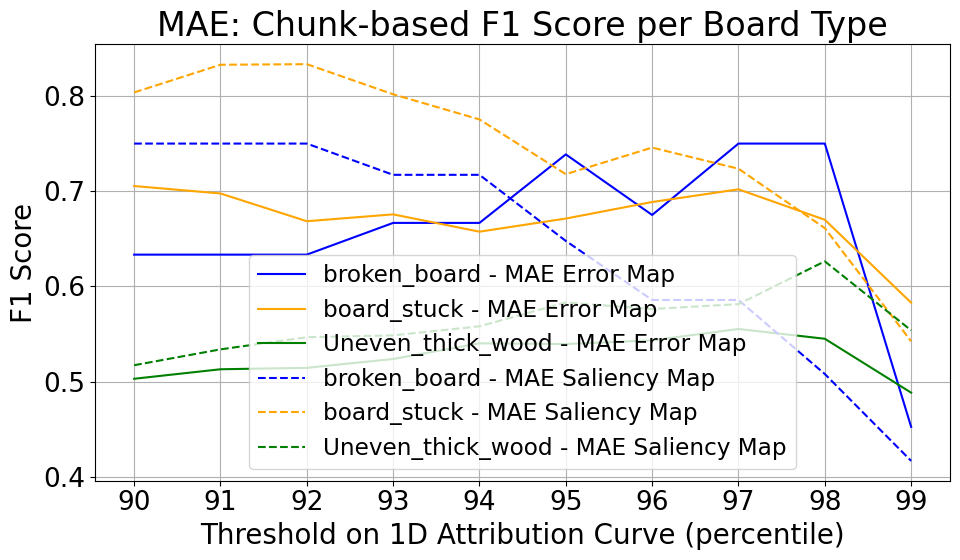

In [9]:

from models.ConvolutionalAutoEncoderWithSkipAndTransformer import ConvolutionalAutoEncoderWithSkipAndTransformer
from trainer.dataloader import CustomDataset as AEDataset
from trainer.maskdataloader import CustomDataset as MAEDataset
from tqdm import tqdm

seed_value = 1986
torch.manual_seed(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

anomaly_models = ['AE', 'MAE']
percentiles = np.arange(90, 100, 1)
f1_curves = {}
f1_curves_saliency = {}
f1_curves_ig = {}
f1_curves_smoothgrad = {}
f1_curves_gradcam = {}
f1_curves_shap = {}

p_curves = {}
r_curves = {}
p_curves_saliency = {}
r_curves_saliency = {}

qualitative_plot = True
plot_file = False

for anomaly_model in anomaly_models:
    if anomaly_model == 'AE':
        dataset = AEDataset(["data/evaluation/normal/"])
        d_anomalies = AEDataset([
            "data/evaluation/anomalies/broken_board/",
            "data/evaluation/anomalies/board_stuck/",
            "data/evaluation/anomalies/Uneven_thick_wood/",
        ], return_directory=True)
    elif anomaly_model == 'MAE':
        dataset = MAEDataset(["data/evaluation/normal/"])
        d_anomalies = MAEDataset([
            "data/evaluation/anomalies/broken_board/",
            "data/evaluation/anomalies/board_stuck/",
            "data/evaluation/anomalies/Uneven_thick_wood/",
        ], return_directory=True)


    if anomaly_model == 'AE':
        v_transformer_cae = ModelTrainer(num_input=401, num_input_channels=80, # standard ae
                                         batch_size=32,
                                         name=f"cae-transformer",
                                         network_class=ConvolutionalAutoEncoderWithSkipAndTransformer,
                                         lr=1e-3,
                                         loss=F.mse_loss) # returns reconstruction map
        
    elif anomaly_model == 'MAE':
        v_transformer_cae = ModelTrainer(num_input=400, num_input_channels=80, # mae
                                         batch_size=32,
                                         name=f"patched-mae-{patchsize}-{int(maskratio*100)}",
                                         network_class=ConvolutionalAutoEncoderWithSkipAndTransformer,
                                         lr=1e-3,
                                         loss=F.mse_loss) # returns reconstruction map

    v_transformer_cae.train([], [])
    print(f"[{anomaly_model}] Model loaded...")
    
    all_f1s = []
    all_f1s_saliency = []
    all_f1s_ig = []
    all_f1s_smoothgrad = []
    all_f1s_gradcam = []
    all_f1s_shap = []
    
    all_ps = []
    all_rs = []
    all_ps_saliency = []
    all_rs_saliency = []
    if anomaly_model == 'MAE':
        board_type_f1s = {'broken_board': [], 'board_stuck': [], 'Uneven_thick_wood': []}
        board_type_f1s_saliency = {'broken_board': [], 'board_stuck': [], 'Uneven_thick_wood': []}
    
    for i, data in tqdm(enumerate(d_anomalies), total=len(d_anomalies)):
        if anomaly_model == 'AE':
            input_tensor = data[0].reshape(80, -1).tolist() # ae
            input_tensor = torch.tensor(input_tensor, dtype=torch.float32)
            filepath = data[1]
        elif anomaly_model == 'MAE':
            input_tensor = data[1][0].reshape(80, -1) # mae
            filepath = data[2]

        filename = os.path.basename(filepath)
        if filename not in annotation_dict:
            continue

        annotations = annotation_dict[filename]
        if anomaly_model == 'MAE':
            board_type = type_dict.get(filename)
            if board_type not in board_type_f1s:
                continue  # skip unknown board types
        
        per_file_f1 = []
        per_file_f1_saliency = []
        per_file_f1_ig = []
        per_file_f1_smoothgrad = []
        per_file_f1_gradcam = []
        per_file_f1_shap = []
        
        per_file_p = []
        per_file_r = []
        per_file_p_saliency = []
        per_file_r_saliency = []
        
        # compute error map
        error_map = v_transformer_cae.get_loss(input_tensor.unsqueeze(0), return_2d_error_map=True).squeeze(0)
        curve_e = error_map.sum(axis=0)

        # generate saliency map
        saliency_map = compute_saliency_map(v_transformer_cae.model.network, input_tensor) # [80, 400]
        # Aggregate saliency over frequency → 1D curve
        curve_saliency = saliency_map.sum(axis=0)
        
        # compute ig map
        ig_map = compute_integrated_gradients(v_transformer_cae.model.network, input_tensor)
        curve_ig = ig_map.sum(axis=0)
        
        smoothgrad_map = compute_smoothgrad(v_transformer_cae.model.network, input_tensor)
        curve_smoothgrad = smoothgrad_map.sum(axis=0)

        # For Grad-CAM, using conv 10 encoder layer
        gradcam_map = compute_gradcam(v_transformer_cae.model.network, input_tensor, target_layer=v_transformer_cae.model.network.conv10).squeeze(0)
        # print('gradcam_map shape', gradcam_map.shape)
        curve_gradcam = gradcam_map.sum(axis=0)

        # compute grad shap map
        shap_map = compute_gradient_shap(v_transformer_cae.model.network, input_tensor)
        curve_shap = shap_map.sum(axis=0)

        for PEAK_PERCENTILE in percentiles:
            # Error Map Evaluation
            f1, p, r = evaluate_attribution_map(curve_e, PEAK_PERCENTILE, annotations)
            per_file_f1.append(f1)
            
            per_file_p.append(p)
            per_file_r.append(r)
            
            # Saliency map evaluation
            f1_saliency, p_saliency, r_saliency = evaluate_attribution_map(curve_saliency, PEAK_PERCENTILE, annotations)
            per_file_f1_saliency.append(f1_saliency)
            
            per_file_p_saliency.append(p_saliency)
            per_file_r_saliency.append(r_saliency)
            
            # IG map evaluation
            f1_ig, _, _ = evaluate_attribution_map(curve_ig, PEAK_PERCENTILE, annotations)
            per_file_f1_ig.append(f1_ig)

            # Smooth Grad evaluation
            f1_smoothgrad, _, _ = evaluate_attribution_map(curve_smoothgrad, PEAK_PERCENTILE, annotations)
            per_file_f1_smoothgrad.append(f1_smoothgrad)

            # Grad CAM evaluation
            f1_gradcam, _, _ = evaluate_attribution_map(curve_gradcam, PEAK_PERCENTILE, annotations)
            per_file_f1_gradcam.append(f1_gradcam)
            
            # Grad SHAP evaluation
            f1_shap, _, _ = evaluate_attribution_map(curve_shap, PEAK_PERCENTILE, annotations)
            per_file_f1_shap.append(f1_shap)

        all_f1s.append(per_file_f1)
        all_f1s_saliency.append(per_file_f1_saliency)
        all_f1s_ig.append(per_file_f1_ig)
        all_f1s_smoothgrad.append(per_file_f1_smoothgrad)
        all_f1s_gradcam.append(per_file_f1_gradcam)
        all_f1s_shap.append(per_file_f1_shap)
        
        all_ps.append(per_file_p)
        all_rs.append(per_file_r)
        all_ps_saliency.append(per_file_p_saliency)
        all_rs_saliency.append(per_file_r_saliency)
        
        if anomaly_model == 'MAE':
            board_type_f1s[board_type].append(per_file_f1)
            board_type_f1s_saliency[board_type].append(per_file_f1_saliency)
        
        if qualitative_plot: # and anomaly_model == 'MAE':
            if filename == "MPD_19-12-05_0949_00008_5.pt": # "MPD_19-12-05_0949_00008_5.pt"✅ , "MPD_19-12-05_0949_00008_4.pt"✅
                board_type = "Broken Board"
                plot_file = True
            # elif filename == "MPD_19-12-04_1124_00162_2.pt": # "MPD_19-12-04_1124_00162_4.pt" ✅ , "MPD_19-12-04_1124_00162_2.pt" ✅
            #     board_type = "Stuck Board"
            #     plot_file = True
            # elif filename == "MPD_19-12-04_1112_00150_1.pt": # "MPD_19-12-04_1112_00150_1.pt"✅✅ , 
            #     # "MPD_19-12-04_1118_00156_3.pt" ✅
            #     board_type = "Uneven/Thick Board"
            #     plot_file = True
            if plot_file:
                visualize_example(
                    input_tensor=input_tensor.cpu(),
                    filename=filename,
                    annotations=annotations,
                    error_map=error_map,
                    saliency_map=saliency_map,
                    ig_map=ig_map,
                    smoothgrad_map=smoothgrad_map,
                    gradcam_map=gradcam_map,
                    shap_map=shap_map,
                    error_curve=curve_e,
                    saliency_curve=curve_saliency,
                    ig_curve=curve_ig,
                    smoothgrad_curve=curve_smoothgrad,
                    gradcam_curve=curve_gradcam,
                    shap_curve=curve_shap,
                    percentiles=[98],  # Optional: focus on last 5 thresholds
                    method_name=anomaly_model, board_type=board_type
                )
            plot_file = False

    mean_f1 = np.mean(all_f1s, axis=0)
    mean_f1_saliency = np.mean(all_f1s_saliency, axis=0)
    mean_f1_ig = np.mean(all_f1s_ig, axis=0)
    mean_f1_smoothgrad = np.mean(all_f1s_smoothgrad, axis=0)
    mean_f1_gradcam = np.mean(all_f1s_gradcam, axis=0)
    mean_f1_shap = np.mean(all_f1s_shap, axis=0)
    
    mean_p = np.mean(all_ps, axis=0)
    mean_r = np.mean(all_rs, axis=0)
    mean_p_saliency = np.mean(all_ps_saliency, axis=0)
    mean_r_saliency = np.mean(all_rs_saliency, axis=0)
    
    f1_curves[anomaly_model.upper()+" Error Map"] = mean_f1
    f1_curves_saliency[anomaly_model.upper()+" Saliency Map"] = mean_f1_saliency
    f1_curves_ig[anomaly_model.upper()+" IG"] = mean_f1_ig
    f1_curves_smoothgrad[anomaly_model.upper()+" Smooth Grad"] = mean_f1_smoothgrad
    f1_curves_gradcam[anomaly_model.upper()+" Grad CAM"] = mean_f1_gradcam
    f1_curves_shap[anomaly_model.upper()+" Grad SHAP"] = mean_f1_shap
    
    p_curves[anomaly_model.upper()+" Error Map"] = mean_p
    r_curves[anomaly_model.upper()+" Error Map"] = mean_r
    p_curves_saliency[anomaly_model.upper()+" Saliency Map"] = mean_p_saliency
    r_curves_saliency[anomaly_model.upper()+" Saliency Map"] = mean_r_saliency
    
    if anomaly_model == 'MAE':
        f1_curves_per_board = {}
        f1_curves_saliency_per_board = {}
        for board_type in board_type_f1s:
            f1_matrix = np.array(board_type_f1s[board_type])
            f1_sal_matrix = np.array(board_type_f1s_saliency[board_type])
    
            mean_f1_board = f1_matrix.mean(axis=0)
            mean_f1_saliency_board = f1_sal_matrix.mean(axis=0)
    
            f1_curves_per_board[f"{board_type} - MAE Error Map"] = mean_f1_board
            f1_curves_saliency_per_board[f"{board_type} - MAE Saliency Map"] = mean_f1_saliency_board
            
        # Find the index of the 98th percentile
        percentile_index = np.where(percentiles == 98)[0][0]  # Get the index of 98 in the array
        print("Mean F1 Scores at 98th Percentile (MAE Error Map)")
        for board_label, mean_f1_curve in f1_curves_per_board.items():
            # f1 = mean_f1_curve[percentile_index]
            # print(f"{board_label}: F1 = {f1:.3f}")
            print(f"{board_label}: F1 = ", mean_f1_curve)
        print("\n Mean F1 Scores at 98th Percentile (MAE Saliency Map)")
        for board_label, mean_f1_curve in f1_curves_saliency_per_board.items():
            # f1 = mean_f1_curve[percentile_index]
            # print(f"{board_label}: F1 = {f1:.3f}")
            print(f"{board_label}: F1 = ", mean_f1_curve)

        # Plot F1 curves per board type (only MAE - best result)
        colors = ['blue', 'orange', 'green']
        plt.figure(figsize=(10, 6))
        i = 0
        for label, f1_scores in f1_curves_per_board.items():
            plt.plot(percentiles, f1_scores, label=label, color=colors[i])
            i += 1
        i=0
        for label, f1_scores in f1_curves_saliency_per_board.items():
            plt.plot(percentiles, f1_scores, label=label, linestyle='--', color=colors[i])
            i+=1
        plt.xlabel("Threshold on 1D Attribution Curve (percentile)")
        plt.ylabel("F1 Score")
        plt.title("MAE: Chunk-based F1 Score per Board Type")
        plt.grid(True)
        plt.legend(loc='best', fontsize='small')
        plt.xticks(percentiles[::1])
        # plt.yticks(np.arange(0.0,1.0,0.1))
        plt.tight_layout()
        plt.show()



## generate f1 score curves

In [9]:

for b in set(type_dict.values()):
    print(b, ': ', len(board_type_f1s[b]))
    
# === Plot all F1 curves ===
base_fontsize = 8.5
plt.rcParams.update({
    'font.size': base_fontsize,
    'axes.labelsize': base_fontsize,
    'xtick.labelsize': base_fontsize,
    'ytick.labelsize': base_fontsize,
    'legend.fontsize': base_fontsize - 1,
    'figure.titlesize': base_fontsize,
})
plt.figure(figsize=(6, 3))
colors=['green', 'red', 'blue', 'purple', 'orange', 'grey']

def plot_f1_curve(f1_dict, linecolor, linestyle='-', marker_color='black', show_max_label=False):
    for i, (label, f1_scores) in enumerate(f1_dict.items()):
        if 'MAE' in label:
            plt.plot(percentiles, f1_scores, label=label, color=linecolor, linestyle='-')
        elif 'AE' in label:
            plt.plot(percentiles, f1_scores, label=label, color=linecolor, linestyle='--')
        
        # Find max F1 score and corresponding percentile
        max_idx = np.argmax(f1_scores)
        max_f1 = f1_scores[max_idx]
        max_percentile = percentiles[max_idx]
        
        # Mark the max point
        marker_label = 'max score' if show_max_label and i == 1 else None
        plt.plot(max_percentile, max_f1, 'x', color=marker_color, label=marker_label)
        plt.text(max_percentile, max_f1, f'{max_f1:.2f}', fontsize=8,
                 ha='left', va='bottom', color=marker_color)

# Plot each curve set
plot_f1_curve(f1_curves, linecolor=colors[0])
plot_f1_curve(f1_curves_saliency, linecolor=colors[1])
plot_f1_curve(f1_curves_ig, linecolor=colors[2])
plot_f1_curve(f1_curves_smoothgrad, linecolor=colors[3])
plot_f1_curve(f1_curves_gradcam, linecolor=colors[4])
plot_f1_curve(f1_curves_shap, linecolor=colors[5], show_max_label=True)

plt.xlabel("Threshold Percentile")
plt.ylabel("F1 Score")
# plt.title("Segment-based F1 Score vs. 1D Attribution Curve Threshold")
plt.grid(True)
plt.xticks(percentiles[::1])  # keep as is or reduce if too crowded
# plt.legend(loc='best', fontsize='small')
# Legend outside
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(right=0.75)

# plt.show()
plt.savefig("visualizations/f1_score_plot.pdf", format="pdf", bbox_inches='tight')
plt.close()



broken_board :  2
Uneven_thick_wood :  34
board_stuck :  10


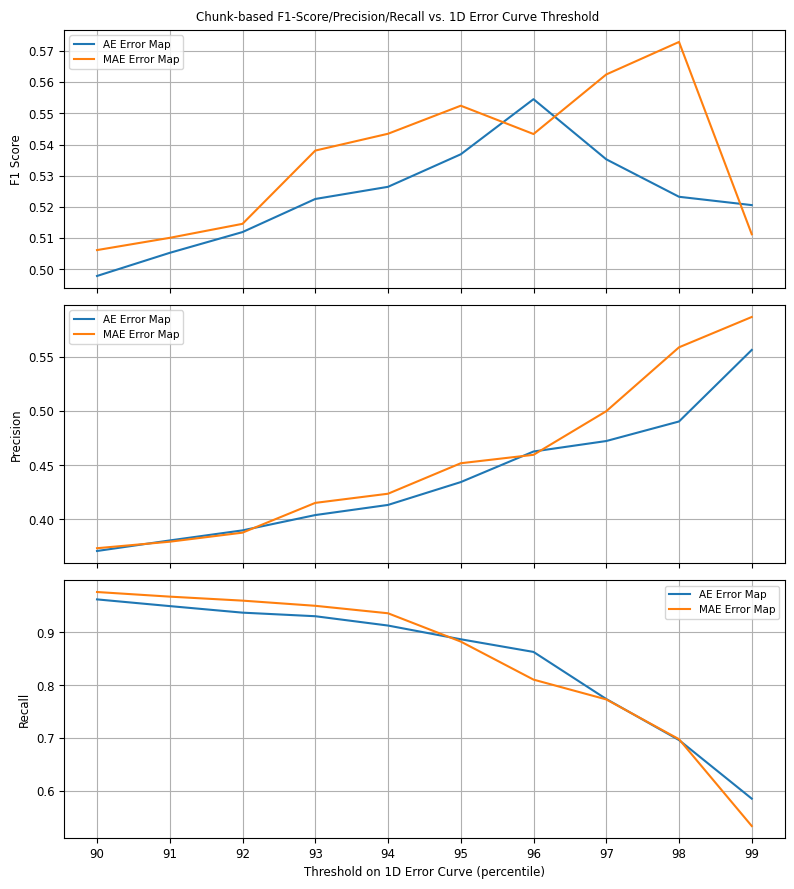

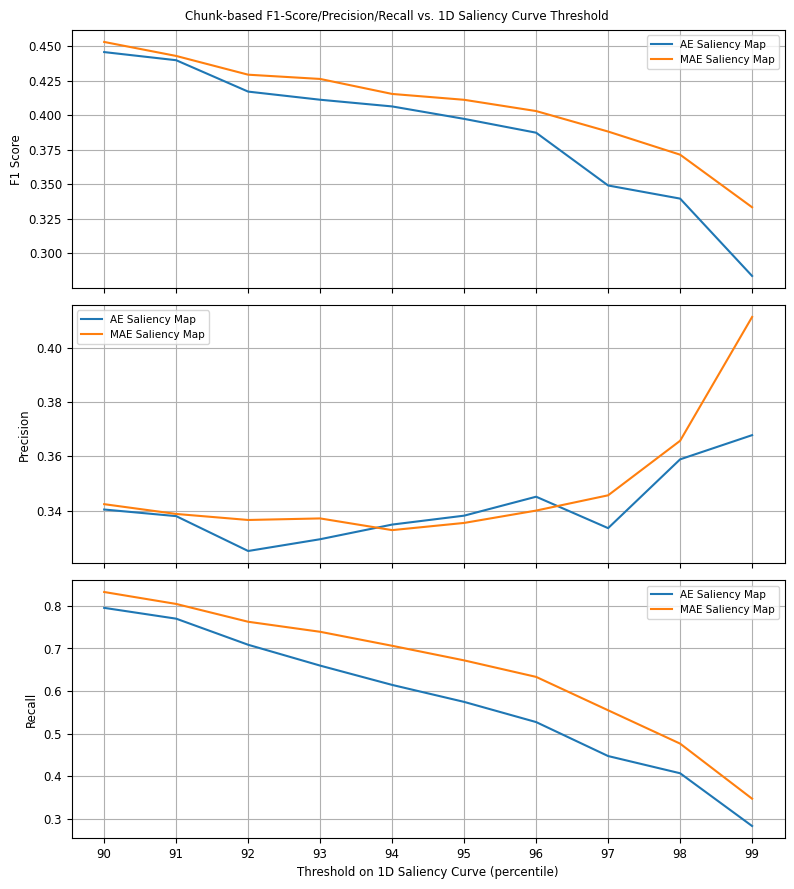

In [44]:

# === Plot Error Map F1 curve ===
fig, ax = plt.subplots(3, 1, figsize=(8, 3 * 3), sharex=True)
for label, f1_scores in f1_curves.items():
    ax[0].plot(percentiles, f1_scores, label=label)
ax[0].set_ylabel("F1 Score")

for label, p_scores in p_curves.items():
    ax[1].plot(percentiles, p_scores, label=label)
ax[1].set_ylabel("Precision")

for label, r_scores in r_curves.items():
    ax[2].plot(percentiles, r_scores, label=label)
ax[2].set_ylabel("Recall")

plt.xlabel("Threshold on 1D Error Curve (percentile)")
plt.suptitle("Chunk-based F1-Score/Precision/Recall vs. 1D Error Curve Threshold")
ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)
ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.xticks(percentiles[::1])  # every 2nd tick: 80, 82, ..., 98
plt.tight_layout()
plt.show()

# === Plot Saliency Map F1 curve ===
fig, ax = plt.subplots(3, 1, figsize=(8, 3 * 3), sharex=True)
for label, f1_scores in f1_curves_saliency.items():
    ax[0].plot(percentiles, f1_scores, label=label)
ax[0].set_ylabel("F1 Score")

for label, p_scores in p_curves_saliency.items():
    ax[1].plot(percentiles, p_scores, label=label)
ax[1].set_ylabel("Precision")

for label, r_scores in r_curves_saliency.items():
    ax[2].plot(percentiles, r_scores, label=label)
ax[2].set_ylabel("Recall")

plt.xlabel("Threshold on 1D Saliency Curve (percentile)")
plt.suptitle("Chunk-based F1-Score/Precision/Recall vs. 1D Saliency Curve Threshold")
ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)
ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.xticks(percentiles[::1])  # every 2nd tick: 80, 82, ..., 98
plt.tight_layout()
plt.show()



## compute faithfulness

In [45]:

import matplotlib.patches as patches

def get_chunk_mask(attribution_curve, threshold_percentile, chunk_size=40):
    """
    Convert a frame-level attribution curve into a chunk-wise binary mask.
    """
    device = attribution_curve.device
    T = attribution_curve.shape[0]
    num_chunks = (T + chunk_size - 1) // chunk_size
    threshold = torch.quantile(attribution_curve, threshold_percentile / 100.0)

    chunk_mask = torch.zeros(num_chunks, device=device)
    for i in range(num_chunks):
        start = i * chunk_size
        end = min((i + 1) * chunk_size, T)
        chunk_importance = attribution_curve[start:end]
        if (chunk_importance >= threshold).any():
            chunk_mask[i] = 1.0

    # Expand chunk mask to time dimension
    mask_1d = torch.zeros(T, device=device)
    for i in range(num_chunks):
        if chunk_mask[i] == 1.0:
            start = i * chunk_size
            end = min((i + 1) * chunk_size, T)
            mask_1d[start:end] = 1.0

    return mask_1d

def restrict_mask_to_annotations(mask_1d, annotations, chunk_size=40): # in case of segment based ff
    restricted_mask = torch.zeros_like(mask_1d, device=mask_1d.device)
    for start, end in annotations:
        restricted_mask[start:end] = mask_1d[start:end]
    return restricted_mask

def compute_faithfulness(model, input_tensor, attribution_curve, top_percentile, annotations, chunk_based=False, chunk_size=40, tp_ff=False):
    """
    Compute faithfulness score by modifying the input using the model reconstruction.
    """
    device = next(model.parameters()).device
    input_tensor = input_tensor.to(device)

    if isinstance(attribution_curve, np.ndarray):
        attribution_curve = torch.tensor(attribution_curve, dtype=torch.float32)
    attribution_curve = attribution_curve.to(device)

    with torch.no_grad():
        x_hat_ae = model(input_tensor.unsqueeze(0)).squeeze(0)

        threshold = torch.quantile(attribution_curve, top_percentile / 100.0)
        if chunk_based:
            mask_1d = get_chunk_mask(attribution_curve, top_percentile, chunk_size) # [T]
            if tp_ff:
                mask_1d = restrict_mask_to_annotations(mask_1d, annotations, chunk_size)
        else:
            mask_1d = (attribution_curve >= threshold).float()  # [T]
        mask = mask_1d.unsqueeze(0).expand_as(input_tensor)  # [C, T]

        x_modified = mask * x_hat_ae + (1 - mask) * input_tensor
        x_modified_hat = model(x_modified.unsqueeze(0)).squeeze(0)

        err_original = F.mse_loss(x_hat_ae, input_tensor)
        err_modified = F.mse_loss(x_modified_hat, x_modified)

        faithfulness_score = torch.max(torch.tensor(0.0, device=err_original.device, dtype=err_original.dtype), 1.0 - (err_modified / err_original)).item()

    return faithfulness_score

def mask_to_segments(mask_1d):
    """Convert a 1D binary mask to a list of (start, end) tuples."""
    segments = []
    mask_np = mask_1d.cpu().numpy()
    start = None
    for i, val in enumerate(mask_np):
        if val == 1 and start is None:
            start = i
        elif val == 0 and start is not None:
            segments.append((start, i))
            start = None
    if start is not None:
        segments.append((start, len(mask_np)))
    return segments

def ff_visualize_example(
    input_tensor,
    filename,
    annotations,
    error_curve,
    percentiles,
    model,
    method_name="AE",
    chunk_based=False,
    chunk_size=40,
    tp_ff=False,
):
    """
    Visualizes:
    - Input Spectrogram
    - Model Reconstruction
    - 1D Error Curve with highlighted spikes
    - Modified Input
    """

    cmap = 'inferno'
    device = next(model.parameters()).device
    input_tensor = input_tensor.to(device)
    base_fontsize = 9
    plt.rcParams.update({
        'font.size': base_fontsize,
        'axes.labelsize': base_fontsize,
        'xtick.labelsize': base_fontsize - 1,
        'ytick.labelsize': base_fontsize - 1,
        'legend.fontsize': base_fontsize - 3.0,
        'figure.titlesize': base_fontsize,
    })

    fig, axes = plt.subplots(2, 2, figsize=(6.8, 3.6), sharex=True)
    
    # Input Spectrogram
    axes[0][0].imshow(input_tensor.cpu(), aspect='auto', origin='lower', cmap=cmap)
    axes[0][0].set_title("Original Input")
    # axes[0].axis('off')
    # axes[0][0].set_xlabel("Time")
    axes[0][0].set_ylabel("Frequency")
    axes[0][0].set_xticks(range(0, input_tensor.shape[1], 50))

    # Model Reconstruction
    with torch.no_grad():
        x_hat_ae = model(input_tensor.unsqueeze(0)).squeeze(0)
    axes[0][1].imshow(x_hat_ae.cpu(), aspect='auto', origin='lower', cmap=cmap)
    axes[0][1].set_title("Model Reconstruction")
    # axes[0][1].axis('off')
    # axes[0][1].set_xlabel("Time")
    axes[0][1].set_xticks(range(0, input_tensor.shape[1], 50))

    # Error Curve Plot
    error_curve_tensor = error_curve.clone().detach().to(dtype=torch.float32, device=device)

    error_np = error_curve_tensor.cpu().numpy()
    
    # Highlight top X% -like 2%- as spikes
    threshold = torch.quantile(error_curve_tensor, percentiles[-2] / 100.0)
    spike_indices = (error_curve_tensor >= threshold).nonzero(as_tuple=True)[0].cpu().numpy()
    
    axes[1][0].plot(error_np, color='black')
    axes[1][0].scatter(spike_indices, error_np[spike_indices], color='red', s=15, label="Peaks @ 98th")
    # Shade replaced regions in light gray
    if chunk_based:
        mask_1d = get_chunk_mask(error_curve_tensor, percentiles[-2], chunk_size)
        if tp_ff:
            mask_1d = restrict_mask_to_annotations(mask_1d, annotations, chunk_size)
    else:
        mask_1d = (error_curve_tensor >= threshold).float()
    mask_segments = mask_to_segments(mask_1d)
    for start, end in mask_segments:
        axes[1][0].axvspan(start, end, color='gray', alpha=0.3)
    axes[1][0].set_title("Error Curve")
    axes[1][0].set_xlabel("Time")
    axes[1][0].set_ylabel("98th norm")
    axes[1][0].legend()
    axes[1][0].set_xticks(range(0, input_tensor.shape[1], 50))

    # Modified Input
    mask = mask_1d.unsqueeze(0).expand_as(input_tensor)

    x_modified = mask * x_hat_ae + (1 - mask) * input_tensor
    axes[1][1].imshow(x_modified.cpu(), aspect='auto', origin='lower', cmap=cmap)
    axes[1][1].set_title("Modified Input")
    axes[1][1].set_xlabel("Time")
    axes[1][1].set_xticks(range(0, input_tensor.shape[1], 50))

    # plt.tight_layout()
    fig.savefig('visualizations/ffsegmnt.pdf', format='pdf', bbox_inches='tight')
    print('saved...')
    plt.show()

    plt.close()
    


[AE] Model loaded...


  0%|          | 0/105 [00:00<?, ?it/s]

Prediction steps: 1 0.01s                          


  3%|▎         | 3/105 [00:01<00:53,  1.91it/s]

Prediction steps: 1 0.01s                          


  4%|▍         | 4/105 [00:03<01:25,  1.18it/s]

Prediction steps: 1 0.01s                          


 11%|█▏        | 12/105 [00:04<00:32,  2.88it/s]

Prediction steps: 1 0.01s                          


 13%|█▎        | 14/105 [00:06<00:38,  2.35it/s]

Prediction steps: 1 0.01s                          


 14%|█▍        | 15/105 [00:07<00:52,  1.72it/s]

Prediction steps: 1 0.01s                          


 15%|█▌        | 16/105 [00:09<01:06,  1.33it/s]

Prediction steps: 1 0.01s                          


 22%|██▏       | 23/105 [00:10<00:34,  2.37it/s]

Prediction steps: 1 0.01s                          


 23%|██▎       | 24/105 [00:12<00:44,  1.82it/s]

Prediction steps: 1 0.01s                          


 24%|██▍       | 25/105 [00:14<00:58,  1.38it/s]

Prediction steps: 1 0.01s                          


 25%|██▍       | 26/105 [00:15<01:08,  1.16it/s]

Prediction steps: 1 0.01s                          


 27%|██▋       | 28/105 [00:17<01:05,  1.18it/s]

Prediction steps: 1 0.01s                          


 30%|██▉       | 31/105 [00:19<00:53,  1.38it/s]

Prediction steps: 1 0.01s                          


 33%|███▎      | 35/105 [00:20<00:40,  1.75it/s]

Prediction steps: 1 0.01s                          


 39%|███▉      | 41/105 [00:22<00:26,  2.39it/s]

Prediction steps: 1 0.01s                          


 45%|████▍     | 47/105 [00:23<00:20,  2.81it/s]

Prediction steps: 1 0.01s                          


 46%|████▌     | 48/105 [00:25<00:26,  2.18it/s]

Prediction steps: 1 0.01s                          


 47%|████▋     | 49/105 [00:26<00:32,  1.70it/s]

Prediction steps: 1 0.01s                          


 48%|████▊     | 50/105 [00:28<00:40,  1.36it/s]

Prediction steps: 1 0.01s                          


 52%|█████▏    | 55/105 [00:30<00:26,  1.90it/s]

Prediction steps: 1 0.01s                          


 55%|█████▌    | 58/105 [00:31<00:25,  1.86it/s]

Prediction steps: 1 0.01s                          


 56%|█████▌    | 59/105 [00:33<00:30,  1.49it/s]

Prediction steps: 1 0.01s                          


 58%|█████▊    | 61/105 [00:35<00:31,  1.39it/s]

Prediction steps: 1 0.01s                          


 59%|█████▉    | 62/105 [00:36<00:36,  1.17it/s]

Prediction steps: 1 0.01s                          


 60%|██████    | 63/105 [00:38<00:41,  1.01it/s]

Prediction steps: 1 0.01s                          


 62%|██████▏   | 65/105 [00:39<00:37,  1.07it/s]

Prediction steps: 1 0.01s                          


 64%|██████▍   | 67/105 [00:41<00:33,  1.14it/s]

Prediction steps: 1 0.01s                          


 66%|██████▌   | 69/105 [00:43<00:30,  1.19it/s]

Prediction steps: 1 0.01s                          


 67%|██████▋   | 70/105 [00:44<00:33,  1.04it/s]

Prediction steps: 1 0.01s                          


 69%|██████▊   | 72/105 [00:46<00:29,  1.11it/s]

Prediction steps: 1 0.01s                          


 70%|██████▉   | 73/105 [00:47<00:32,  1.03s/it]

Prediction steps: 1 0.01s                          


 73%|███████▎  | 77/105 [00:49<00:19,  1.43it/s]

Prediction steps: 1 0.01s                          


 74%|███████▍  | 78/105 [00:50<00:22,  1.19it/s]

Prediction steps: 1 0.01s                          


 75%|███████▌  | 79/105 [00:52<00:25,  1.03it/s]

Prediction steps: 1 0.01s                          


 78%|███████▊  | 82/105 [00:54<00:17,  1.28it/s]

Prediction steps: 1 0.01s                          


 83%|████████▎ | 87/105 [00:55<00:09,  1.88it/s]

Prediction steps: 1 0.01s                          


 84%|████████▍ | 88/105 [00:57<00:11,  1.50it/s]

Prediction steps: 1 0.01s                          


 85%|████████▍ | 89/105 [00:58<00:12,  1.28it/s]

Prediction steps: 1 0.01s                          


 86%|████████▌ | 90/105 [01:00<00:13,  1.08it/s]

Prediction steps: 1 0.01s                          


 87%|████████▋ | 91/105 [01:01<00:14,  1.06s/it]

Prediction steps: 1 0.01s                          


 92%|█████████▏| 97/105 [01:03<00:04,  1.82it/s]

Prediction steps: 1 0.01s                          


 94%|█████████▍| 99/105 [01:04<00:03,  1.67it/s]

Prediction steps: 1 0.01s                          


 95%|█████████▌| 100/105 [01:06<00:03,  1.39it/s]

Prediction steps: 1 0.01s                          


 96%|█████████▌| 101/105 [01:07<00:03,  1.18it/s]

Prediction steps: 1 0.01s                          


 98%|█████████▊| 103/105 [01:09<00:01,  1.21it/s]

Prediction steps: 1 0.01s                          


 99%|█████████▉| 104/105 [01:10<00:00,  1.06it/s]

Prediction steps: 1 0.01s                          


100%|██████████| 105/105 [01:12<00:00,  1.46it/s]


[MAE] Model loaded...


  0%|          | 0/105 [00:00<?, ?it/s]

Prediction steps: 1 0.01s                          
saved...


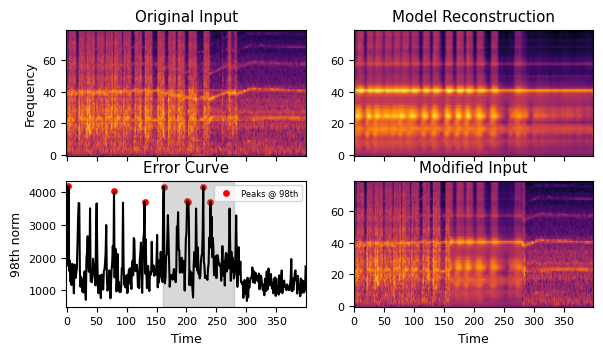

  3%|▎         | 3/105 [00:02<01:19,  1.28it/s]

Prediction steps: 1 0.01s                          


  4%|▍         | 4/105 [00:03<01:45,  1.04s/it]

Prediction steps: 1 0.01s                          


 11%|█▏        | 12/105 [00:05<00:35,  2.63it/s]

Prediction steps: 1 0.01s                          


 13%|█▎        | 14/105 [00:07<00:42,  2.13it/s]

Prediction steps: 1 0.01s                          


 14%|█▍        | 15/105 [00:08<00:54,  1.67it/s]

Prediction steps: 1 0.01s                          


 15%|█▌        | 16/105 [00:10<01:06,  1.34it/s]

Prediction steps: 1 0.01s                          


 22%|██▏       | 23/105 [00:11<00:34,  2.34it/s]

Prediction steps: 1 0.01s                          


 23%|██▎       | 24/105 [00:13<00:44,  1.81it/s]

Prediction steps: 1 0.01s                          


 24%|██▍       | 25/105 [00:14<00:54,  1.47it/s]

Prediction steps: 1 0.01s                          


 25%|██▍       | 26/105 [00:16<01:03,  1.25it/s]

Prediction steps: 1 0.01s                          


 27%|██▋       | 28/105 [00:17<00:59,  1.29it/s]

Prediction steps: 1 0.01s                          


 30%|██▉       | 31/105 [00:19<00:48,  1.51it/s]

Prediction steps: 1 0.01s                          


 33%|███▎      | 35/105 [00:20<00:38,  1.81it/s]

Prediction steps: 1 0.01s                          


 39%|███▉      | 41/105 [00:22<00:26,  2.40it/s]

Prediction steps: 1 0.01s                          


 45%|████▍     | 47/105 [00:23<00:20,  2.86it/s]

Prediction steps: 1 0.01s                          


 46%|████▌     | 48/105 [00:25<00:26,  2.15it/s]

Prediction steps: 1 0.01s                          


 47%|████▋     | 49/105 [00:27<00:33,  1.69it/s]

Prediction steps: 1 0.01s                          


 48%|████▊     | 50/105 [00:28<00:39,  1.40it/s]

Prediction steps: 1 0.01s                          


 52%|█████▏    | 55/105 [00:30<00:25,  1.97it/s]

Prediction steps: 1 0.01s                          


 55%|█████▌    | 58/105 [00:31<00:24,  1.92it/s]

Prediction steps: 1 0.01s                          


 56%|█████▌    | 59/105 [00:33<00:29,  1.54it/s]

Prediction steps: 1 0.01s                          


 58%|█████▊    | 61/105 [00:34<00:29,  1.48it/s]

Prediction steps: 1 0.01s                          


 59%|█████▉    | 62/105 [00:36<00:33,  1.27it/s]

Prediction steps: 1 0.01s                          


 60%|██████    | 63/105 [00:37<00:38,  1.10it/s]

Prediction steps: 1 0.01s                          


 62%|██████▏   | 65/105 [00:39<00:34,  1.15it/s]

Prediction steps: 1 0.01s                          


 64%|██████▍   | 67/105 [00:40<00:31,  1.21it/s]

Prediction steps: 1 0.01s                          


 66%|██████▌   | 69/105 [00:42<00:28,  1.24it/s]

Prediction steps: 1 0.01s                          


 67%|██████▋   | 70/105 [00:43<00:33,  1.05it/s]

Prediction steps: 1 0.01s                          


 69%|██████▊   | 72/105 [00:45<00:28,  1.14it/s]

Prediction steps: 1 0.01s                          


 70%|██████▉   | 73/105 [00:46<00:32,  1.02s/it]

Prediction steps: 1 0.01s                          


 73%|███████▎  | 77/105 [00:48<00:18,  1.49it/s]

Prediction steps: 1 0.01s                          


 74%|███████▍  | 78/105 [00:49<00:21,  1.25it/s]

Prediction steps: 1 0.01s                          


 75%|███████▌  | 79/105 [00:51<00:23,  1.09it/s]

Prediction steps: 1 0.01s                          


 78%|███████▊  | 82/105 [00:52<00:16,  1.37it/s]

Prediction steps: 1 0.01s                          


 83%|████████▎ | 87/105 [00:54<00:09,  1.98it/s]

Prediction steps: 1 0.01s                          


 84%|████████▍ | 88/105 [00:55<00:10,  1.60it/s]

Prediction steps: 1 0.01s                          


 85%|████████▍ | 89/105 [00:57<00:12,  1.32it/s]

Prediction steps: 1 0.01s                          


 86%|████████▌ | 90/105 [00:58<00:13,  1.14it/s]

Prediction steps: 1 0.01s                          


 87%|████████▋ | 91/105 [00:59<00:14,  1.00s/it]

Prediction steps: 1 0.01s                          


 92%|█████████▏| 97/105 [01:01<00:04,  1.90it/s]

Prediction steps: 1 0.01s                          


 94%|█████████▍| 99/105 [01:02<00:03,  1.74it/s]

Prediction steps: 1 0.01s                          


 95%|█████████▌| 100/105 [01:04<00:03,  1.41it/s]

Prediction steps: 1 0.01s                          


 96%|█████████▌| 101/105 [01:05<00:03,  1.18it/s]

Prediction steps: 1 0.01s                          


 98%|█████████▊| 103/105 [01:07<00:01,  1.22it/s]

Prediction steps: 1 0.01s                          


 99%|█████████▉| 104/105 [01:08<00:00,  1.07it/s]

Prediction steps: 1 0.01s                          


100%|██████████| 105/105 [01:10<00:00,  1.49it/s]


In [49]:


from models.ConvolutionalAutoEncoderWithSkipAndTransformer import ConvolutionalAutoEncoderWithSkipAndTransformer
from trainer.dataloader import CustomDataset as AEDataset
from trainer.maskdataloader import CustomDataset as MAEDataset
from tqdm import tqdm

seed_value = 1986
torch.manual_seed(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

anomaly_models = ['AE', 'MAE']
percentiles = np.arange(90, 100, 1)
ff_curves = {}
ff_curves_saliency = {}
ff_curves_ig = {}
ff_curves_smoothgrad = {}
ff_curves_gradcam = {}
ff_curves_shap = {}

qualitative_plot = True
plot_file = False
chunk_based=True # True (segment-based) , False (frame-based)
tp_ff=True # True (in case of segment-based) , False (in case of frame-based)

for anomaly_model in anomaly_models:
    if anomaly_model == 'AE':
        dataset = AEDataset(["data/evaluation/normal/"])
        d_anomalies = AEDataset([
            "data/evaluation/anomalies/broken_board/",
            "data/evaluation/anomalies/board_stuck/",
            "data/evaluation/anomalies/Uneven_thick_wood/",
        ], return_directory=True)
    elif anomaly_model == 'MAE':
        dataset = MAEDataset(["data/evaluation/normal/"])
        d_anomalies = MAEDataset([
            "data/evaluation/anomalies/broken_board/",
            "data/evaluation/anomalies/board_stuck/",
            "data/evaluation/anomalies/Uneven_thick_wood/",
        ], return_directory=True)


    if anomaly_model == 'AE':
        v_transformer_cae = ModelTrainer(num_input=401, num_input_channels=80, # standard ae
                                         batch_size=1,
                                         name=f"cae-transformer-noseed",
                                         network_class=ConvolutionalAutoEncoderWithSkipAndTransformer,
                                         lr=1e-3,
                                         loss=F.mse_loss) # returns reconstruction map
        
    elif anomaly_model == 'MAE':
        v_transformer_cae = ModelTrainer(num_input=400, num_input_channels=80, # mae
                                         batch_size=1,
                                         name=f"patched-mae-{patchsize}-{int(maskratio*100)}-noseed",
                                         network_class=ConvolutionalAutoEncoderWithSkipAndTransformer,
                                         lr=1e-3,
                                         loss=F.mse_loss) # returns reconstruction map

    v_transformer_cae.train([], [])
    print(f"[{anomaly_model}] Model loaded...")
    
    all_ffs = []
    all_ffs_saliency = []
    all_ffs_ig = []
    all_ffs_smoothgrad = []
    all_ffs_gradcam = []
    all_ffs_shap = []
    
    for i, data in tqdm(enumerate(d_anomalies), total=len(d_anomalies)):
        if anomaly_model == 'AE':
            input_tensor = data[0].reshape(80, -1).tolist() # ae
            input_tensor = torch.tensor(input_tensor, dtype=torch.float32)
            filepath = data[1]
        elif anomaly_model == 'MAE':
            input_tensor = data[1][0].reshape(80, -1) # mae
            filepath = data[2]

        filename = os.path.basename(filepath)
        if filename not in annotation_dict:
            continue

        annotations = annotation_dict[filename]
        
        per_file_ff = []
        per_file_ff_saliency = []
        per_file_ff_ig = []
        per_file_ff_smoothgrad = []
        per_file_ff_gradcam = []
        per_file_ff_shap = []
        
        # compute error map
        error_map = v_transformer_cae.get_loss(input_tensor.unsqueeze(0), return_2d_error_map=True).squeeze(0)
        curve_e = error_map.sum(axis=0)

        # generate saliency map
        saliency_map = compute_saliency_map(v_transformer_cae.model.network, input_tensor) # [80, 400]
        # Aggregate saliency over frequency → 1D curve
        curve_saliency = saliency_map.sum(axis=0)
        
        # compute ig map
        ig_map = compute_integrated_gradients(v_transformer_cae.model.network, input_tensor)
        curve_ig = ig_map.sum(axis=0)
        
        smoothgrad_map = compute_smoothgrad(v_transformer_cae.model.network, input_tensor)
        curve_smoothgrad = smoothgrad_map.sum(axis=0)

        # For Grad-CAM, you must know which layer to use
        gradcam_map = compute_gradcam(v_transformer_cae.model.network, input_tensor, target_layer=v_transformer_cae.model.network.conv10).squeeze(0)
        # print('gradcam_map shape', gradcam_map.shape)
        curve_gradcam = gradcam_map.sum(axis=0)

        # compute grad shap map
        shap_map = compute_gradient_shap(v_transformer_cae.model.network, input_tensor)
        curve_shap = shap_map.sum(axis=0)

        for PEAK_PERCENTILE in percentiles:
            # Error Map Evaluation
            ff = compute_faithfulness(v_transformer_cae.model.network, input_tensor, curve_e, PEAK_PERCENTILE, annotations, chunk_based=chunk_based, tp_ff=tp_ff)
            per_file_ff.append(ff)
            
            # Saliency map evaluation
            ff_saliency = compute_faithfulness(v_transformer_cae.model.network, input_tensor, curve_saliency, PEAK_PERCENTILE, annotations, chunk_based=chunk_based, tp_ff=tp_ff)
            per_file_ff_saliency.append(ff_saliency)
            
            # IG map evaluation
            ff_ig = compute_faithfulness(v_transformer_cae.model.network, input_tensor, curve_ig, PEAK_PERCENTILE, annotations, chunk_based=chunk_based, tp_ff=tp_ff)
            per_file_ff_ig.append(ff_ig)

            # Smooth Grad evaluation
            ff_smoothgrad = compute_faithfulness(v_transformer_cae.model.network, input_tensor, curve_smoothgrad, PEAK_PERCENTILE, annotations, chunk_based=chunk_based, tp_ff=tp_ff)
            per_file_ff_smoothgrad.append(ff_smoothgrad)

            # Grad CAM evaluation
            ff_gradcam = compute_faithfulness(v_transformer_cae.model.network, input_tensor, curve_gradcam, PEAK_PERCENTILE, annotations, chunk_based=chunk_based, tp_ff=tp_ff)
            per_file_ff_gradcam.append(ff_gradcam)
            
            # Grad SHAP evaluation
            ff_shap = compute_faithfulness(v_transformer_cae.model.network, input_tensor, curve_shap, PEAK_PERCENTILE, annotations, chunk_based=chunk_based, tp_ff=tp_ff)
            per_file_ff_shap.append(ff_shap)

        all_ffs.append(per_file_ff)
        all_ffs_saliency.append(per_file_ff_saliency)
        all_ffs_ig.append(per_file_ff_ig)
        all_ffs_smoothgrad.append(per_file_ff_smoothgrad)
        all_ffs_gradcam.append(per_file_ff_gradcam)
        all_ffs_shap.append(per_file_ff_shap)
        
        if qualitative_plot and anomaly_model == 'MAE':
            if filename == "MPD_19-12-05_0949_00008_5.pt":
                board_type = "Broken Board"
                plot_file = True

            if plot_file:
                ff_visualize_example(
                    input_tensor=input_tensor.cpu(),
                    filename=filename,
                    annotations=annotations,
                    error_curve=curve_e,
                    percentiles=percentiles[-5:],  # Optional: focus on last 5 thresholds
                    method_name=anomaly_model, #board_type=board_type,
                    model=v_transformer_cae.model.network,
                    chunk_based=chunk_based, tp_ff=tp_ff,
                )
            plot_file = False

    mean_ff = np.mean(all_ffs, axis=0)
    mean_ff_saliency = np.mean(all_ffs_saliency, axis=0)
    mean_ff_ig = np.mean(all_ffs_ig, axis=0)
    mean_ff_smoothgrad = np.mean(all_ffs_smoothgrad, axis=0)
    mean_ff_gradcam = np.mean(all_ffs_gradcam, axis=0)
    mean_ff_shap = np.mean(all_ffs_shap, axis=0)
    
    ff_curves[anomaly_model.upper()+" Error Map"] = mean_ff
    ff_curves_saliency[anomaly_model.upper()+" Saliency Map"] = mean_ff_saliency
    ff_curves_ig[anomaly_model.upper()+" IG"] = mean_ff_ig
    ff_curves_smoothgrad[anomaly_model.upper()+" Smooth Grad"] = mean_ff_smoothgrad
    ff_curves_gradcam[anomaly_model.upper()+" Grad CAM"] = mean_ff_gradcam
    ff_curves_shap[anomaly_model.upper()+" Grad SHAP"] = mean_ff_shap




**Note:** run the previous cell twice to run the following two cells so to save the segemnt based and frame based evaluations respectively by setting: 

chunk_based=True, tp_ff=True for segemnt based ff

chunk_based=False, tp_ff=False for frame based ff


In [51]:
fr_ff_curves, fr_ff_curves_saliency, fr_ff_curves_ig, fr_ff_curves_smoothgrad, fr_ff_curves_gradcam, fr_ff_curves_shap = ff_curves, ff_curves_saliency, ff_curves_ig, ff_curves_smoothgrad, ff_curves_gradcam, ff_curves_shap




In [10]:
seg_ff_curves, seg_ff_curves_saliency, seg_ff_curves_ig, seg_ff_curves_smoothgrad, seg_ff_curves_gradcam, seg_ff_curves_shap = ff_curves, ff_curves_saliency, ff_curves_ig, ff_curves_smoothgrad, ff_curves_gradcam, ff_curves_shap




save the ff curves

In [ ]:
# Ensure all *_ff_curves_* dicts are defined BEFORE this

base_fontsize = 8.5
plt.rcParams.update({
    'font.size': base_fontsize,
    'axes.labelsize': base_fontsize,
    'xtick.labelsize': base_fontsize,
    'ytick.labelsize': base_fontsize,
    'legend.fontsize': base_fontsize - 1,
    'figure.titlesize': base_fontsize,
})

colors = ['green', 'red', 'blue', 'purple', 'orange', 'grey']
percentiles = list(range(90, 100))

# Create figure with 2 subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(6.8, 2.8))
# plt.subplots_adjust(bottom=0.25)

def plot_ff_curve(ax, ff_dict, linecolor):
    for i, (label, ff_scores) in enumerate(ff_dict.items()):
        if 'MAE' in label:
            ax.plot(percentiles, ff_scores, label=label, color=linecolor, linestyle='-')
        elif 'AE' in label:
            ax.plot(percentiles, ff_scores, label=label, color=linecolor, linestyle='--')

# Left: Frame-based
for idx, ff_dict in enumerate([fr_ff_curves, fr_ff_curves_saliency, fr_ff_curves_ig, fr_ff_curves_smoothgrad, fr_ff_curves_gradcam, fr_ff_curves_shap]):
    plot_ff_curve(axes[0], ff_dict, linecolor=colors[idx])

axes[0].set_title("Frame-based")
axes[0].set_xlabel("Threshold Percentile")
axes[0].set_ylabel("Faithfulness Score")
axes[0].grid(True)

# Right: Segment-based
for idx, ff_dict in enumerate([seg_ff_curves, seg_ff_curves_saliency, seg_ff_curves_ig, seg_ff_curves_smoothgrad, seg_ff_curves_gradcam, seg_ff_curves_shap]):
    plot_ff_curve(axes[1], ff_dict, linecolor=colors[idx])

axes[1].set_title("Segment-based")
axes[1].set_xlabel("Threshold Percentile")
axes[1].grid(True)

# Shared legend
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, fontsize='small', bbox_to_anchor=(0.5, -0.15))

# Layout
plt.tight_layout()
plt.subplots_adjust(bottom=0.3)

# Save the figure
plt.savefig("visualizations/combined_ff_plot.pdf", format="pdf") #, bbox_inches='tight')
plt.close()
